[TensorRT] WARNING: Using an engine plan file across different models of devices is not recommended and is likely to affect performance or even cause errors.
[TensorRT] WARNING: TensorRT was linked against cuDNN 8.2.1 but loaded cuDNN 8.2.0
[TensorRT] WARNING: TensorRT was linked against cuDNN 8.2.1 but loaded cuDNN 8.2.0


self.engine.get_binding_shape(i) : (12, 34, 60)
self.engine.get_binding_shape(i) : (3, 34, 60)
self.out_shape [(24480,), (6120,)]
input_data.shape 1  torch.Size([1566720]) [[426, 640]]
output_datas[0].shape torch.Size([24480]) torch.Size([6120])
bindings [140031524895744, 140031524994048]
bindings [140030202871808, 140031524895744, 140031524994048]
outputs[0].shape : (24480,)
outputs[1].shape : (6120,)
bbox : [1.0877376  1.67242    2.841372   ... 0.5986968  0.43259037 0.61556065]
bbox.shape : (24480,)
t3_2 ~ t3_1 : 0.004086732864379883
t3_2 ~ t3_1 : 0.003421306610107422
t3_2 ~ t3_1 : 0.003734111785888672
indexes [98 76 93 31]
t1~t2 : 0.00018215179443359375
t2~t3 : 3.5762786865234375e-06
t3~t4 : 0.011928558349609375
t4~t5 : 0.0002658367156982422
[{'bbox': [442, 60, 489, 127], 'score': 0.9997161030769348, 'label': 2}, {'bbox': [292, 47, 346, 122], 'score': 0.9995859861373901, 'label': 2}, {'bbox': [175, 65, 222, 131], 'score': 0.9993962049484253, 'label': 2}, {'bbox': [111, 36, 412, 423]

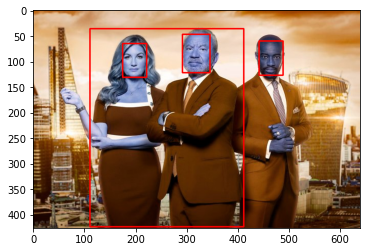

In [1]:
import argparse
import os
import sys
import numpy as np
import tensorrt as trt
import cv2
import torchvision
import torch
import time
import traceback
import importlib
import common_people as common
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

torch.cuda.init()


class PEOPLE_DETECTOR:
    def __init__(self):  
#     def __init__(self, logger):  
#         self.logger = logger

        
        self.num_classes = list(range(3))
        self.threshold = 0.7


        self.input_h = 544
        self.input_w = 960
        self.wh_format = True

        self.stride = 16
        self.box_norm = 35.0
        self.grid_calculator()

    def load(self, weights):
        self.weights = weights
        self.Engine = common.Engine()      
        self.Engine.make_context(self.weights)
        self.batchsize = 1

    def parse_input(self,input_data_batch):
        res = []
        for input_data in input_data_batch:
            frame = input_data['framedata']['frame']
            bbox = input_data['bbox']
            cropped_img = common.getCropByFrame(frame,bbox)
            res.append(cropped_img)
        return res
    
    
    def grid_calculator(self):
        self.grid_h = int(self.input_h / self.stride)
        self.grid_w = int(self.input_w / self.stride)
        self.grid_size = self.grid_h * self.grid_w

        self.grid_centers_w = []
        self.grid_centers_h = []

        for i in range(self.grid_h):
            value = (i * self.stride + 0.5) / self.box_norm
            self.grid_centers_h.append(value)

        for i in range(self.grid_w):
            value = (i * self.stride + 0.5) / self.box_norm
            self.grid_centers_w.append(value)
        
    
    
    def applyBoxNorm(self,o1, o2, o3, o4, x, y):
        """
        Applies the GridNet box normalization
        Args:
            o1 (float): first argument of the result
            o2 (float): second argument of the result
            o3 (float): third argument of the result
            o4 (float): fourth argument of the result
            x: row index on the grid
            y: column index on the grid

        Returns:
            float: rescaled first argument
            float: rescaled second argument
            float: rescaled third argument
            float: rescaled fourth argument
        """
        o1 = (o1 - self.grid_centers_w[x]) * -self.box_norm
        o2 = (o2 - self.grid_centers_h[y]) * -self.box_norm
        o3 = (o3 + self.grid_centers_w[x]) * self.box_norm
        o4 = (o4 + self.grid_centers_h[y]) * self.box_norm
        return o1, o2, o3, o4
    
    def NMSBoxes(self, bboxes,scores,class_ids, outputs_list,scale_list):
        indexes = cv2.dnn.NMSBoxes(bboxes, scores, self.threshold, 0.5)
        print('indexes',indexes)
        ori_h = scale_list[0][0]
        ori_w = scale_list[0][1]
        
        for idx in indexes:
            idx = int(idx)
            xmin, ymin, w, h = bboxes[idx]
            xmax = w + xmin
            ymax = h + ymin
            
            ori_x_min = int((xmin * ori_w)/self.input_w)
            ori_y_min = int((ymin * ori_h)/self.input_h)
            
            ori_x_max = int((xmax * ori_w)/self.input_w)
            ori_y_max = int((ymax * ori_h)/self.input_h)
            
            
            class_id = class_ids[idx]
            score = scores[idx]
            output = {"bbox":[ori_x_min, ori_y_min, ori_x_max, ori_y_max], "score":score, "label":class_id}
            outputs_list.append(output)
        return outputs_list

    def postprocess(self,outputs, scale_list):
        """
        Postprocesses the inference output
        Args:
            outputs (list of float): inference output
            min_confidence (float): min confidence to accept detection
            analysis_classes (list of int): indices of the classes to consider

        Returns: list of list tuple: each element is a two list tuple (x, y) representing the corners of a bb
        """
        t1 = time.time()
        outputs[0] = outputs[0].detach().cpu().numpy()
        outputs[1] = outputs[1].detach().cpu().numpy()
        print(f"outputs[0].shape : {outputs[0].shape}")
        print(f"outputs[1].shape : {outputs[1].shape}")
        
        t2 = time.time()
        outputs_list = []
        bbs = []
        class_ids = []
        scores = []
        if isinstance(outputs[0], type(None)):
            return
        
        
        t3 = time.time()  
        boxes = outputs[0]
        
        print(f"bbox : {boxes}")
        print(f"bbox.shape : {boxes.shape}")        
        for c in self.num_classes:

            x1_idx = c * 4 * self.grid_size
            y1_idx = x1_idx + self.grid_size
            x2_idx = y1_idx + self.grid_size
            y2_idx = x2_idx + self.grid_size
                
            t3_1 = time.time()
            for h in range(self.grid_h):
                for w in range(self.grid_w):
                    i = w + h * self.grid_w
                    score = outputs[1][c * self.grid_size + i]
                    if score >= self.threshold:
                        o1 = boxes[x1_idx + i]
                        o2 = boxes[y1_idx + i]
                        o3 = boxes[x2_idx + i]
                        o4 = boxes[y2_idx + i]
#                         o1 = boxes[x1_idx + w + h * self.grid_w]
#                         o2 = boxes[y1_idx + w + h * self.grid_w]
#                         o3 = boxes[x2_idx + w + h * self.grid_w]
#                         o4 = boxes[y2_idx + w + h * self.grid_w]
                        

                        o1, o2, o3, o4 = self.applyBoxNorm(o1, o2, o3, o4, w, h)

                        xmin = int(o1)
                        ymin = int(o2)
                        xmax = int(o3)
                        ymax = int(o4)
                        if self.wh_format:
                            bbs.append([xmin, ymin, xmax - xmin, ymax - ymin])
                        else:
                            bbs.append([xmin, ymin, xmax, ymax])
                        class_ids.append(c)
                        scores.append(float(score))
            t3_2 = time.time()
            print(f"t3_2 ~ t3_1 : {t3_2 - t3_1}")

        t4 = time.time()                
        outputs_list = self.NMSBoxes(bbs,scores,class_ids,outputs_list,scale_list)
        t5 = time.time()
        
        print(f"t1~t2 : {t2-t1}")
        print(f"t2~t3 : {t3-t2}")
        print(f"t3~t4 : {t4-t3}")
        print(f"t4~t5 : {t5-t4}")
        


        
        
        return outputs_list

    def preprocess(self,frame_batch) : 

        input_data = torch.zeros([3, self.input_h, self.input_w], dtype=torch.float32, device=torch.device("cuda")).fill_(144)
        scale_list = []
        
        for idx, frame in enumerate(frame_batch) :
            _, h, w = frame.shape
            permute = [2, 1, 0]
            frame = frame[permute,:,:]
            resized_img = torchvision.transforms.functional.resize(frame, (self.input_h, self.input_w)).float()
            resized_img = resized_img.div(255.0)
            input_data[:,:self.input_h,:self.input_w] = resized_img 
            input_data = torch.ravel(input_data)
            scale_list.append([h,w])
        print('input_data.shape 1 ',input_data.shape,scale_list)
        return input_data, scale_list

    
    def inference(self,input_data) : 
        output_data = self.Engine.do_inference_v2(input_data)
        return output_data

    
#     def parse_output(self,input_data_batch,output_batch,reference_CM):
    def parse_output(self,output_batch):
        res = []
        idx_i = 0
        for idx_i, data in enumerate(input_data_batch): 
            if output_batch == None:
                input_data = dict()
                input_data["framedata"] = framedata
                input_data["bbox"] = None
                input_data["scenario"] = scenario   
                input_data["data"] = None
                input_data["available"] = False
                res.append(input_data)
                continue
            for idx_j, output in enumerate(output_batch): 
                print('output',output)
                if isinstance(output, type(None)):
                    input_data = dict()
                    input_data["framedata"] = framedata
                    input_data["bbox"] = None
                    input_data["scenario"] = scenario   
                    input_data["data"] = None   
                    input_data["available"] = False
                    res.append(input_data)
                    continue

                input_data = dict()
                input_data["framedata"] = framedata
                input_data["bbox"] = output['bbox']
                input_data["scenario"] = scenario   
                input_data["data"] = {"score":output['score'], "label":str(label)}
                input_data["available"] = True
                res.append(input_data)
        return res  
        
   
    
weights = '/DATA_17/ij/test/best_model_people.trt'

img_path = '/DATA_17/ij/test/test_image.jpeg'
# image = cv2.imread(img_path)[..., ::-1]#BGR 순서를 RGB로 뒤집습니다.
image = cv2.imread(img_path)
image = np.copy(image)
image = torch.from_numpy(image).to(torch.device("cuda"))
image = image.permute(2,0,1)
frame_batch = [image]



pe = PEOPLE_DETECTOR()
pe.load(weights)


input_data, scale_list = pe.preprocess(frame_batch)

result = pe.inference(input_data)


output_batch = pe.postprocess(result, scale_list)

print(output_batch)

image = cv2.imread(img_path)


for result in output_batch:
    xmin, ymin, xmax, ymax = result['bbox']
    color = [255, 0, 0] 
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
plt.imshow(image)
plt.show()


